### importações

In [61]:
!pip install d2l numpy==1.26.4

In [62]:
! python --version


Python 3.12.11


In [63]:
#importações
import os
import tensorflow as tf
from d2l import tensorflow as d2l

### Carregando os dados

In [64]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



### Pré-processamento

In [65]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


### Tokenização


In [66]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

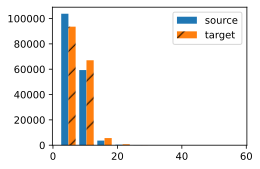

In [67]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [68]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [69]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [70]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(
        tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

In [71]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [72]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=600)
print(f"tamanho vocab origem: {len(src_vocab)} tokens")
print(f"tamanho vocab destino: {len(tgt_vocab)} tokens")
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

tamanho vocab origem: 184 tokens
tamanho vocab destino: 201 tokens
X: tf.Tensor(
[[  6 143   4   3   1   1   1   1]
 [ 13  46  48   4   3   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([4 5], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[  6   0   4   3   1   1   1   1]
 [ 80  23 193   5   3   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([4 5], shape=(2,), dtype=int32)


In [73]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=1200)
print(f"tamanho vocab origem: {len(src_vocab)} tokens")
print(f"tamanho vocab destino: {len(tgt_vocab)} tokens")
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

tamanho vocab origem: 314 tokens
tamanho vocab destino: 384 tokens
X: tf.Tensor(
[[  5  65   8   4   3   1   1   1]
 [273  98   4   3   1   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([5 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[ 17 211   4   3   1   1   1   1]
 [  6   0   4   3   1   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([4 4], shape=(2,), dtype=int32)


In [74]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=6000)
print(f"tamanho vocab origem: {len(src_vocab)} tokens")
print(f"tamanho vocab destino: {len(tgt_vocab)} tokens")
print("=" * 50)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

tamanho vocab origem: 1037 tokens
tamanho vocab destino: 1454 tokens
X: tf.Tensor(
[[ 72   8   4   3   1   1   1   1]
 [158  98   4   3   1   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([4 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[882   6   3   1   1   1   1   1]
 [914   6   3   1   1   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([3 3], shape=(2,), dtype=int32)


`'num_examples'` é o número de frases. Quanto maior o número nesse parâmetro, maior o número de frases do dataset serão usadas no treinamento. Com mais frases, maior o vocabulário, posto que quanto mais frases usamos, mais palavras diferentes aparecem (aumentando o número de tokens).

Ao usar 600 exemplos, o vocabulário de origem tem 184 tokens e o de destino 201 tokens; com 1.200 exemplos, 314 e 384; com 6.000 exemplos, 1.037 para origem 1.454 para o destino. Isso aumenta o número de palavras conhecidas, mas também aumenta o custo computacional. Ademais, com esses testes, nota-se que o crescimento do vocabulário foi mais relevante ao dobrar o número de frases e mais suave ao fazer 10x, mostrando que o crescimento não é linear.

Por possuirem sistemas linguísticos diferentes, não podemos aplicar as mesmas regras que usamos nas línguas ocidentais. Não faz sentido analisar da mesma forma, posto que não há com identificar palavras a partir do espaço. Nessas línguas com ideogramas, o ideal é identificar cada ideograma, o que pode ser feito analisando cada caractere.

Para cada língua, é necessário identificar a unidade linguística mais coerente com a análise. Em línguas ocidentais, as palavras podem ser usadas; em linguas como japones e chines, ideogramas ou caracteres são melhores; em línguas semíticas, poderíamos usar os radicais como tokens ou separar por unidades mínimas de sentido (desconhecido -> des, conhec, ido), dentro da classificação morfológica, para tokenizar, posto que por ser templática, o custo computacional de processar todas as palavras seria muito alto.